## Problem Statement: Using Machine Learning to Classify Aerial Imagery to Determine Areas Where Drones Can Safely Land

Our project has multiple goals:

1. Split the satellite image into 300 by 300 images
2. Re-size those images into 128 by 128
3. Feature extraction: HSL histograms, RGB histograms, and Edge Magnitude histograms
4. Models: RF, Logistic Regression, SVM, Decision Tree, Gaussian Naive Bayes
5. Run the RF + three feature extraction method on the satellite images

We are given a 7000-image dataset consisting of 128 by 128 sized images. We use various feature extraction methods along with different models and see which did best. Once we did that, we implemented the same models and feature extraction methods on the satellite images. We then put the satellite images back together and tinted certain areas green and red (to determine whether or not it is safe to land there).

### Loading in the Data

In [1]:
# Importing all libraries

from ml_helpers import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from cv_helpers import load_image, visualize_single_channel, rgb2hsl, visualize_rgb
from cv_helpers import hsl2rgb, visualize_rgb
import scipy.signal
from tqdm.auto import tqdm
import sklearn.model_selection
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from project_helpers import pad_image, normalize, histogram_single_channel

In [2]:
# Loading in all images and labels

images_all, labels_all = load_dataset()

Reading dataset/dataset.yaml... done!
Loading images.................... done!
Loaded 6888 images in 63.70514392852783 seconds!


### Loading Satellite Images
1. Load in the satellite images from folder
2. Crop them into 300 by 300 images
3. Store the 300 by 300 images in arrays

#### Loading in and Visualizing the Images

In [3]:
# using load_image function from cv_helpers.py

neighborhood_img = load_image("neighborhood.jpeg")

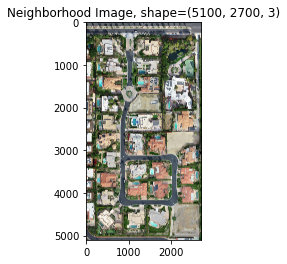

In [4]:
# using visualize_rgb function from cv_helpers.py

visualize_rgb("Neighborhood Image", neighborhood_img)

In [5]:
# using load_image function from cv_helpers.py

construction_img = load_image("construction.jpeg")

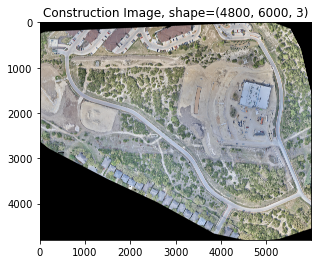

In [6]:
# using visualize_rgb function from cv_helpers.py

visualize_rgb("Construction Image", construction_img)

#### Cropping the Images and Storing Them in Arrays

Trying to split the images into 300 by 300.

In [7]:
# Creating a function that will crop the images into 300 by 300
def crop_satellite_image(image):
    """ Crop a large image into 300 by 300 images
    
    Args:
        image (np.ndarray): the input 2-d numpy array
    
    Returns:
        images: an array that contains all the 300 by 300 images
    """

    m = image.shape[0]
    n = image.shape[1]
    
    # creating an empty array that can hold all the pixel values of each image
    images = np.zeros(((m // 300) * (n // 300), 300, 300, 3))
    
    # using this to keep track of each 300 by 300 image
    count = 0
    
    # looping through the empty images array
    for i in range(0, m, 300):
        for j in range(0, n, 300):
            images[count] = image[i:i+300, j:j+300, :]
            count += 1
    
    # returning the array that contains all the images
    return images

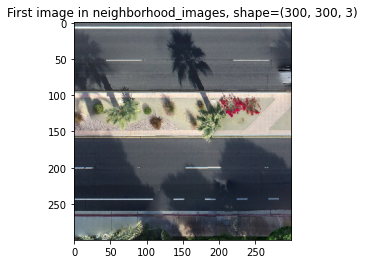

In [8]:
# creating an array that holds all the 300 by 300 images for neighborhood_img
neighborhood_images = crop_satellite_image(neighborhood_img)

# visualizing the first image (top left)
visualize_rgb("First image in neighborhood_images", neighborhood_images[0])

One thing we have to keep in mind while working with `construction_images` is that there are a lot of black areas on the map. We will still run these against our model later on in the notebook.

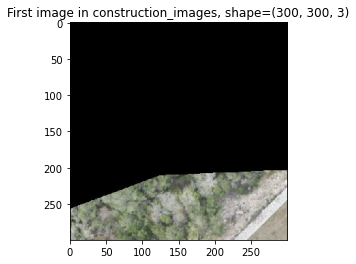

In [9]:
# do the same for construction_img
construction_images = crop_satellite_image(construction_img)

# visualizing the first image (top left)
visualize_rgb("First image in construction_images", construction_images[0])

### Using Edge Magnitudes as Features

This section is mainly defining functions that are going to be used to create edge magnitude histograms.


What we need to do for each image:
1. Convert it to grayscale
2. Create the vertical and horizontal edges by calling `convolve2d` from `scipy`
3. Compute edge magnitudes
4. Create a histogram of the edge magnitudes


Our features list will have the edge orientation histogram for each image.

In [10]:
def extract_edge_magnitude_features(images):
    """Get the edge magnitude histograms for each image in images.
    
    Args:
        images (ndarray): contains all the images we will be working with
    
    Returns:
        features (1d nparray): contains all the edge magnitude histograms for each image
    
    """
    
    features = []
    for image in tqdm(images): # tqdm gives us a progess bar while going through the for loop
        
        # creating black and white image
        image = rgb2hsl(image)[:, :, 2]
        
        # creating horizontal and vertical edge kernels
        vertical_edge_kernel = np.array([
            [-1, 0, 1],
            [-2, 0, 2],
            [-1, 0, 1]
        ])

        horizontal_edge_kernel = np.array([
            [-1, -2, -1],
            [0, 0, 0],
            [1, 2, 1]
        ])
        
        # creating vertical and horizontal edges
        vertical_edges = scipy.signal.convolve2d(image, vertical_edge_kernel, mode="same")
        horizontal_edges = scipy.signal.convolve2d(image, horizontal_edge_kernel, mode="same")
        
        # creating the edge magnitudes        
        edge_magnitudes = np.sqrt(horizontal_edges ** 2 + vertical_edges ** 2)
        
        # creating the edge magnitudes histogram
        edge_magnitudes = normalize(edge_magnitudes)

        bins = 10

        histograms = histogram_single_channel(edge_magnitudes, bins)

        features.append(histograms)
        
        
    return np.array(features)

features_all = extract_edge_magnitude_features(images_all)

#### Implementing Our Model on Edge Magnitude Features

Now that we have our features, let's implement our models. We're going to be using five different types of models: SVM, Logistic Regression, Gaussian Naive Bayes, Random Forest, and Decision Tree.


Let's start by creating a train-test split of our features and labels.

In [11]:
# Get train / validation sets using sklearn.model_selection.train_test_split
(
    images_train,
    images_validation,
    features_train,
    features_validation,
    labels_train,
    labels_validation,
) = sklearn.model_selection.train_test_split(
    images_all,
    features_all,
    labels_all,
    train_size=0.75,
    random_state=42,
    shuffle=True,
)

In [12]:
# Creating a classifier -- uncomment to run

classifier = GaussianNB()
# classifier = svm.SVC()
# classifier = tree.DecisionTreeClassifier()
# classifier = LogisticRegression()
# classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(features_train, labels_train)

GaussianNB()

In [13]:
# Creating our predictions using the classifier
labels_validation_predicted = classifier.predict(features_validation)

In [14]:
# Computing our accuracy

correct = 0
total = len(labels_validation_predicted)
for i in range(len(labels_validation_predicted)):
    if labels_validation_predicted[i] == labels_validation[i]:
        correct += 1

print('Accuracy is', correct/total * 100)

Accuracy is 70.44134727061557


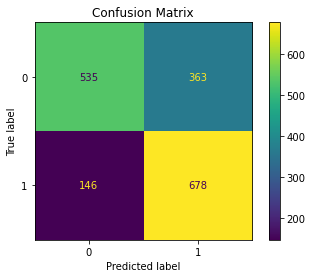

In [15]:
# Creating a confusion matrix

sklearn.metrics.plot_confusion_matrix(classifier, features_validation, labels_validation)
plt.title("Confusion Matrix")
plt.show()

### Using Image Histograms as Features

Now that we've implemented our models with the edge magnitude histograms, we will do the same with image histograms.

In [16]:
def extract_img_features(images):
    """Creating image histograms to use as features
    
    Args:
        images (ndarray): contains all the images we will be creating image histograms of
        
    Returns:
        features (nparray): contains all the image histograms
    """
    
    features = []
    for image in tqdm(images):
        
        histograms = []
        
        bins=10
        
        for i in range(3):
            histograms.append(histogram_single_channel(image[:, :, i], bins))    
            
        histograms = np.array(histograms)
        
        hist = np.concatenate(histograms)
        
        features.append(hist)
        
        
    return np.array(features)

features_all = extract_img_features(images_all)

#### Implementing our Model on Color Histograms

Now that we have our new features, let's implement our models again. We're going to be the same five models.

Let's start like we did previously: by creating a train-test split of our features and labels.

In [17]:
# Get train / validation sets using sklearn.model_selection.train_test_split
(
    images_train,
    images_validation,
    features_train,
    features_validation,
    labels_train,
    labels_validation,
) = sklearn.model_selection.train_test_split(
    images_all,
    features_all,
    labels_all,
    train_size=0.75,
    random_state=42,
    shuffle=True,
)

In [18]:
# Creating a classifier

# classifier = GaussianNB()
classifier = svm.SVC()
# classifier = tree.DecisionTreeClassifier()
# classifier = LogisticRegression()
# classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(features_train, labels_train)

SVC()

In [19]:
# Creating our predictions using the classifier
labels_validation_predicted = classifier.predict(features_validation)

In [20]:
# Computing our accuracy

correct = 0
total = len(labels_validation_predicted)
for i in range(len(labels_validation_predicted)):
    if labels_validation_predicted[i] == labels_validation[i]:
        correct += 1

print('Accuracy is', correct/total * 100)

Accuracy is 82.22996515679442


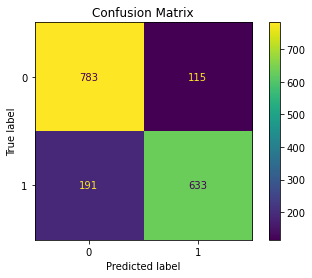

In [21]:
# Creating a confusion matrix

sklearn.metrics.plot_confusion_matrix(classifier, features_validation, labels_validation)
plt.title("Confusion Matrix")
plt.show()

### Using HSL Histograms as Features

Similar to what we did with image histograms, we are creating HSL histograms to use as features for running the model with.

In [22]:
def extract_hsl_features(images):
    """Creating HSL histograms for each image in images.
    
    Args:
        images (ndarray): contains all the images
        
    Returns:
        features (nparray): contains all the HSL histograms for each image in images
    """
        
    features = []
    for image in tqdm(images):

        hsl_image = rgb2hsl(image)
        
        bins=20
        
        histograms = []
        
        for i in range(3):
            histograms.append(histogram_single_channel(hsl_image[:, :, i], bins))
        
        
        features.append(np.array(histograms).flatten())

    return np.array(features)

features_all = extract_hsl_features(images_all)

In [23]:
# Get train / validation sets using sklearn.model_selection.train_test_split
(
    images_train,
    images_validation,
    features_train,
    features_validation,
    labels_train,
    labels_validation,
) = sklearn.model_selection.train_test_split(
    images_all,
    features_all,
    labels_all,
    train_size=0.75,
    random_state=42,
    shuffle=True,
)

In [24]:
# Creating a classifier - uncomment to run

classifier = None

# classifier = GaussianNB()
# classifier = svm.SVC()
# classifier = tree.DecisionTreeClassifier()
# classifier = LogisticRegression()
classifier = RandomForestClassifier()

classifier.fit(features_train, labels_train)

RandomForestClassifier()

In [25]:
# Creating our predictions using the classifier
labels_validation_predicted = classifier.predict(features_validation)

In [26]:
# Computing our accuracy

correct = 0
total = len(labels_validation_predicted)
for i in range(len(labels_validation_predicted)):
    if labels_validation_predicted[i] == labels_validation[i]:
        correct += 1

print('Accuracy is', correct/total * 100)

Accuracy is 86.93379790940766


#### Creating a confusion matrix

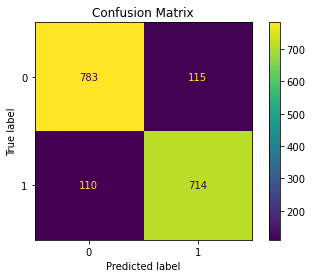

In [27]:
sklearn.metrics.plot_confusion_matrix(classifier, features_validation, labels_validation)
plt.title("Confusion Matrix")
plt.show()

### Implementing our Models on the Satellite Images

Now, we have implemented our models on the three different feature extraction methods, but with the same 6,888 image dataset. 


What we are going to do here is implement our feature extraction methods and models on the 300 by 300 satellite images. However, since the satellite images don't have labels, this is a real-world test to see if the model and feature extraction methods used are good.


**Steps:**


1. Resize the 300 by 300 images into 128 by 128 images
2. Extract the features (both image histograms and edge magnitude histograms)
3. Run our five models
4. Put the image back together and change the hue of each section so that we can see whether or not it is safe to land there.

In [28]:
# importing library we can use to resize

import PIL.Image

In [29]:
# creating list of neighborhood images
n_images = np.zeros((153, 128, 128, 3), dtype=np.float32)

for i, image in enumerate(neighborhood_images):
    n_images[i] = np.array(PIL.Image.fromarray((image * 255).astype(np.uint8)).resize((128, 128))) / 255.0

In [30]:
# extracting regular features
features_all = extract_hsl_features(images_all)

# extracting satellite features
features_all_2 = extract_hsl_features(n_images)

In [31]:
# Using RF classifier (87%)
# training classifier on 6888-image dataset

classifier = RandomForestClassifier()
classifier.fit(features_all, labels_all)

RandomForestClassifier()

In [32]:
# creating predictions on satellite image

labels_validation_predicted = classifier.predict(features_all_2)

#### Visualization
With the images classified and labeled, we can now tint them red or green and stitch them together to create a full satellite image.


In [33]:
# defining function that helps us resize, tint, and put satellite images back together

from project_helpers import tint_red
from project_helpers import tint_green
from project_helpers import resize_image

def process_output(output_shape, chunks, labels_predicted, chunk_rows, chunk_cols):
    """Visualize full satellite image with tinting
    
    Args:
        output_shape(np.array): shape of output image
        chunks(np.array): array of all the chunks of the image that are going to be put together
        labels_predicted(np.array): 'safe' or 'unsafe' labels predicted by classification model
        chunk_rows(int): number of rows of pixels of each image chunk
        chunk_cols(int): number of columns of pixels of each image chunk
    """
    output_img = np.zeros(output_shape)
    chunk_area = chunk_rows * chunk_cols
    
    for i in range (len(chunks)):
        # resize all chunks
        resized = resize_image(chunks[i], chunk_rows, chunk_cols)
        
        # tint all chunks
        if labels_predicted[i] == 0:
            tinted_chunk = tint_red(resized)
        else:
            tinted_chunk = tint_green(resized)
            
        # index into output_img and replace zeros with the chunk values
        rowstart = (i // (output_shape[1] // chunk_cols)) * 300
        colstart = (i * chunk_cols) % output_shape[1]
        output_img[rowstart:rowstart+chunk_rows, colstart:colstart+chunk_cols, :] = tinted_chunk
    return output_img


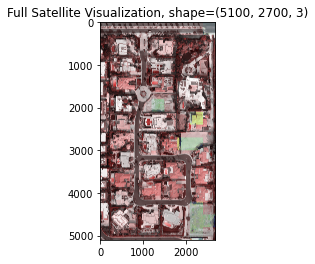

In [35]:
# Using above function to resize, tint, and put satellite images back together

hsl_histogram_n_img_array = process_output(neighborhood_img.shape, n_images, labels_validation_predicted, 300, 300)
hsl_histogram_n_img = visualize_rgb("Full Satellite Visualization", hsl_histogram_n_img_array)

In [36]:
# saving file as larger version
hsl_histogram_n_img_2 = np.array(hsl_histogram_n_img_array*256-1, dtype=np.uint8)

img_file = PIL.Image.fromarray(hsl_histogram_n_img_2)
img_file.save('hsl_histogram_n_img_second_final.png')

### Other Image + More Feature Extraction Methods

Now, let's try working with the other image (`construction_img`). This one is interesting because it has black space around the corners.

In [37]:
# creating list of construction images

c_images = np.zeros((320, 128, 128, 3), dtype=np.float32)

for i, image in enumerate(construction_images):
    c_images[i] = np.array(PIL.Image.fromarray((image * 255).astype(np.uint8)).resize((128, 128))) / 255.0

In [38]:
# extracting original features
features_all = extract_hsl_features(images_all)

# extracting satellite image features
features_all_2 = extract_hsl_features(c_images)

In [39]:
# Creating classifier, training, and making predictions on satellite image

classifier = RandomForestClassifier()
classifier.fit(features_all, labels_all)

labels_validation_predicted = classifier.predict(features_all_2)

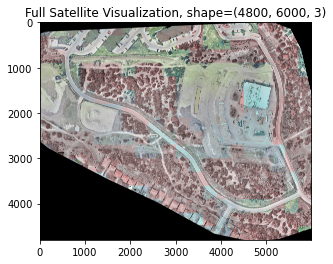

In [40]:
# Resizing, tinting, and putting image back together

hsl_histogram_c_img_array = process_output(construction_img.shape, c_images, labels_validation_predicted, 300, 300)
hsl_histogram_c_img = visualize_rgb("Full Satellite Visualization", hsl_histogram_c_img_array)

In [41]:
#saving file as larger version
hsl_histogram_c_img_2 = np.array(hsl_histogram_c_img_array*256-1, dtype=np.uint8)

img_file_2 = PIL.Image.fromarray(hsl_histogram_c_img_2)
img_file_2.save('hsl_histogram_c_img_second_final.png')

#### Now let's try with image histograms as our features.

We're again going to run image histograms + RF on both satellite images; let's see how they do.

In [42]:
# n_images is already defined, so we skip to features

# features on 6888-image dataset
features_all = extract_img_features(images_all)

# features on satellite image
features_all_2 = extract_img_features(neighborhood_images)

In [43]:
# Creating classifier, fitting on original data, and training on satellite image

classifier = RandomForestClassifier()
classifier.fit(features_all, labels_all)

labels_validation_predicted = classifier.predict(features_all_2)

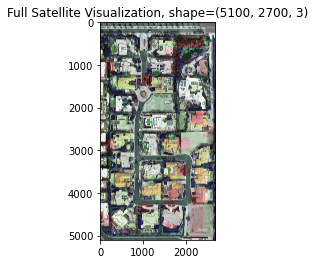

In [44]:
# Resizing, tinting, and putting satellite image back together

rgb_histogram_n_img_array = process_output(neighborhood_img.shape, n_images, labels_validation_predicted, 300, 300)
rgb_histogram_n_img = visualize_rgb("Full Satellite Visualization", rgb_histogram_n_img_array)

In [45]:
# saving file as larger version
rgb_histogram_n_img_2 = np.array(rgb_histogram_n_img_array*256-1, dtype=np.uint8)

img_file = PIL.Image.fromarray(rgb_histogram_n_img_2)
img_file.save('rgb_histogram_n_img_second_final.png')

Now that we've run image histograms on the neighborhood image, let's try on the construction image.

In [46]:
# already defined c_images, so we skip to features

# original features already defined

# new features for constrution image
features_all_2_c = extract_img_features(construction_images)

In [47]:
# RF classifier, training on old data, predicting on satellite image

classifier = RandomForestClassifier()
classifier.fit(features_all, labels_all)

labels_validation_predicted = classifier.predict(features_all_2_c)

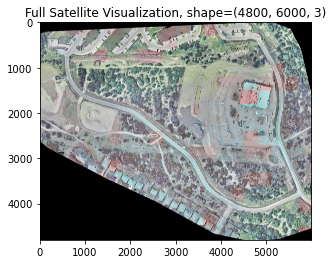

In [48]:
# resize, tint, and put images back together

rgb_histogram_c_img_array = process_output(construction_img.shape, c_images, labels_validation_predicted, 300, 300)
rgb_histogram_c_img = visualize_rgb("Full Satellite Visualization", rgb_histogram_c_img_array)

In [49]:
#saving file as larger version
rgb_histogram_c_img_2 = np.array(rgb_histogram_c_img_array*256-1, dtype=np.uint8)

img_file = PIL.Image.fromarray(rgb_histogram_c_img_2)
img_file.save('rgb_histogram_c_img_second_final.png')

#### Finally, let's try edge detection.

We're again going to use RF on the satellite images, but we're using edge detection as our feature extraction method this time.

In [50]:
# n_images already defined

# creating features for old images
features_all = extract_edge_magnitude_features(images_all)

# creating features for new satellite image
features_all_2_n = extract_edge_magnitude_features(n_images)

In [51]:
# RF trained on old images and predictions made on new satellite image

classifier = RandomForestClassifier()
classifier.fit(features_all, labels_all)
labels_validation_predicted = classifier.predict(features_all_2_n)

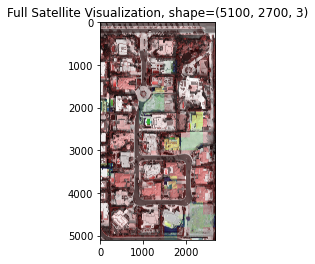

In [52]:
# Resize, tint, and put back together

edge_mag_n_img_array = process_output(neighborhood_img.shape, n_images, labels_validation_predicted, 300, 300)
edge_mag_n_img = visualize_rgb("Full Satellite Visualization", edge_mag_n_img_array)

In [53]:
#saving file as larger version
edge_mag_n_img_2 = np.array(edge_mag_n_img_array*256-1, dtype=np.uint8)

img_file = PIL.Image.fromarray(edge_mag_n_img_2)
img_file.save('edge_mag_n_img_second_final.png')

Finally, let's do edge magnitudes + RF + construction images.

In [54]:
# old features and c_images already defined

# defining new features for satellite image
features_all_2_c = extract_edge_magnitude_features(c_images)

C:\Users\rajay\AI4ALL\project_helpers.py:47: RuntimeWarning: invalid value encountered in true_divide
  output_image = output_image / np.max(output_image)
C:\Users\rajay\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\rajay\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [55]:
# RF trained on old images, predictions made on new satellite images

classifier = RandomForestClassifier()
classifier.fit(features_all, labels_all)
labels_validation_predicted = classifier.predict(features_all_2_c)

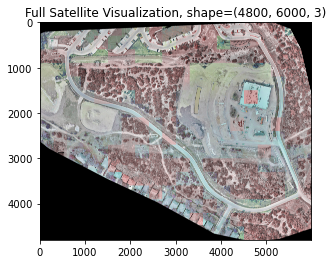

In [56]:
# Resizing, tinting, and putting image back together

edge_mag_c_img_array = process_output(construction_img.shape, c_images, labels_validation_predicted, 300, 300)
edge_mag_c_img = visualize_rgb("Full Satellite Visualization", edge_mag_c_img_array)

In [57]:
#saving file as larger version
edge_mag_c_img_2 = np.array(edge_mag_c_img_array*256-1, dtype=np.uint8)

img_file = PIL.Image.fromarray(edge_mag_c_img_2)
img_file.save('edge_mag_c_img_second_final.png')

## Conclusion

We have completed all our tasks. Just to summarize, we have done the following:


1. Split the satellite image into 300 by 300 images
2. Re-size those images into 128 by 128
3. Feature extraction: HSL histograms, RGB histograms, and Edge Magnitude histograms
4. Models: RF, Logistic Regression, SVM, Decision Tree, Gaussian Naive Bayes
5. Run the RF + three feature extraction method on the satellite images


We found that the model + feature extraction combination that did best was Random Forest, which got an accuracy of 87 percent with the HSL histograms. We then used RF on the satellite images and tried all three feature extraction methods.


In the neighborhood image, RGB and HSL did equally well, and edge detection (surprisingly) did not do as well. We thought that edge detection would be able to tell if there is a building in a certain region, but it did not do that well. For further research, we can try using edge orientations instead of just edge magnitudes.


In the construction image, HSL histograms did better than RGB and edge detection. Overall, all three feature extraction processes told us not to land on the trees or buildings, but mostly on the flat grass or roads with no cars.


View all code and images here: https://github.com/rajayush143/AI4ALL_Code


July 30, 2020


Ayush Raj, Mia Chen